### Notebook for Extracting Contracts Related to Artificial Intelligence, Machine Learning, and Deep Learning

In [1]:
# Importing necessary libraries for data manipulation, visualization, and text processing
import pandas as pd
import os
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter
from bertopic import BERTopic
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer, models
import matplotlib.pyplot as plt
import warnings

# Ignoring deprecation warnings that might clutter the notebook
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Configuring matplotlib to display visuals inline in a Jupyter notebook
%matplotlib inline

# Adjusting Pandas display settings to show unlimited rows and columns with increased column width
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)

# # Downloading NLTK packages necessary for tokenization, stopwords, and lemmatization
import nltk
nltk.download('punkt')     # Tokenizer to split text into words
nltk.download('stopwords') # Common words ('the', 'a', etc.) that usually do not carry much meaning
nltk.download('wordnet')   # Lexical database for the English language, helps in lemmatization

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sankar.kalaga\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sankar.kalaga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sankar.kalaga\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Importing the dataset of contract opportunities from a CSV file
samgov_data = pd.read_csv("ContractOpportunitiesFullCSV.csv", encoding="ansi", dtype="string")

# Filtering the dataset to include only the columns that are relevant for analysis
samgov_data = samgov_data[['Title', 'Sol#', 'Department/Ind.Agency', 'AwardNumber', 'AwardDate', 'PostedDate', 'Award$', 'Awardee', 'Link', 'Description']]

# Removing rows where the 'Department/Ind.Agency' column is missing to ensure data completeness
samgov_data = samgov_data.dropna(subset=['Department/Ind.Agency'])

# Printing the number of rows in the dataset after cleaning to understand the scope of data
print(samgov_data.shape[0])

# Displaying the first few rows of the dataset to get a preview of the data
samgov_data.head()

74040


,Title,Sol#,Department/Ind.Agency,AwardNumber,AwardDate,PostedDate,Award$,Awardee,Link,Description
0,North Field ALCS Computer Upgrade,F1M3E34003AQ02,DEPT OF DEFENSE,<NA>,<NA>,2024-05-21 23:28:08.079-04,<NA>,<NA>,https://sam.gov/opp/d606819a57d0473b9110047867eadf16/view,"THIS IS NOT A REQUEST FOR COMPETITIVE PROPOSALS. This is a notice of intent to award a sole source contract under statutory authority 10 USC 2304(c)(1), set forth in Federal Acquisition Regulation..."
1,Zeiss LSM980 Microscope Upgrade,75N95024Q00305,"HEALTH AND HUMAN SERVICES, DEPARTMENT OF",<NA>,<NA>,2024-05-21 23:03:00.374-04,<NA>,<NA>,https://sam.gov/opp/5417ce1082b84ea182c41aa3631aee5b/view,SAM.gov SOURCES SOUGHT NOTICE Solicitation Number: 75N95024Q00305 Title: Zeiss LSM980 Microscope Upgrade Classification Code: 6640 NAICS Code: 334516 Description: Analytical Laboratory Instru...
2,Maestro Pro Assay System Purchase,75N95024Q00304,"HEALTH AND HUMAN SERVICES, DEPARTMENT OF",<NA>,<NA>,2024-05-21 22:59:18.743-04,<NA>,<NA>,https://sam.gov/opp/754bb52525fe47ec981a96f85e02b2a2/view,SAM.gov SOURCES SOUGHT NOTICE Solicitation Number: 75N95024Q00304 Title: Maestro Pro Assay System Purchase Classification Code: 6640 NAICS Code: 334516 Description: Analytical Laboratory Inst...
3,Maui Wildfire Temporary Debris Storage Operations & Residential Debris Removal,W9128A24R0027,DEPT OF DEFENSE,<NA>,<NA>,2024-05-21 22:53:01.18-04,<NA>,<NA>,https://sam.gov/opp/da6189fb140344f199736f6df314c968/view,"This is a special notice per Federal Acquisition Regulation (FAR) 5.2 – Synopses of Proposed Contract Action. The U.S. Army Corps of Engineers (USACE), Honolulu District (POH), intends to issue a ..."
4,Maui Wildfire Temporary Debris Storage Operations & Residential Debris Removal,W9128A24R0027,DEPT OF DEFENSE,<NA>,<NA>,2024-05-21 22:51:27.869-04,<NA>,<NA>,https://sam.gov/opp/b9ac402b52f247d58294c95274c97b4b/view,"This is a special notice per Federal Acquisition Regulation (FAR) 5.2 – Synopses of Proposed Contract Action. The U.S. Army Corps of Engineers (USACE), Honolulu District (POH), intends to issue a ..."


In [3]:
# Setting the start date for filtering the dataset
start_date = '2017-12-31'

# Cleaning the 'AwardDate' by removing the time part and converting it to a date format
samgov_data['AwardDate'] = samgov_data['AwardDate'].str.replace("T00:00:00", '')
samgov_data['AwardDate'] = pd.to_datetime(samgov_data['AwardDate'], errors='coerce', format='%Y-%m-%d')

# Cleaning 'PostedDate' by isolating the date part and converting it to a date format
samgov_data['PostedDate'] = samgov_data['PostedDate'].str.split(" ").str[0]
samgov_data['PostedDate'] = pd.to_datetime(samgov_data['PostedDate'], errors='coerce')

# Creating a mask to filter rows where 'AwardDate' or 'PostedDate' is greater than the start date
time_mask = (samgov_data['AwardDate'] > start_date) | (samgov_data['PostedDate'] > start_date)

# Applying the mask to the DataFrame to filter relevant data
samgov_data_5yrs = samgov_data[time_mask]

# Printing the number of rows in the filtered dataset to check the amount of data
print(samgov_data_5yrs.shape[0])

# Displaying the first few rows of the filtered dataset for a quick preview
samgov_data_5yrs.head()


72563


,Title,Sol#,Department/Ind.Agency,AwardNumber,AwardDate,PostedDate,Award$,Awardee,Link,Description
0,North Field ALCS Computer Upgrade,F1M3E34003AQ02,DEPT OF DEFENSE,<NA>,NaT,2024-05-21,<NA>,<NA>,https://sam.gov/opp/d606819a57d0473b9110047867eadf16/view,"THIS IS NOT A REQUEST FOR COMPETITIVE PROPOSALS. This is a notice of intent to award a sole source contract under statutory authority 10 USC 2304(c)(1), set forth in Federal Acquisition Regulation..."
1,Zeiss LSM980 Microscope Upgrade,75N95024Q00305,"HEALTH AND HUMAN SERVICES, DEPARTMENT OF",<NA>,NaT,2024-05-21,<NA>,<NA>,https://sam.gov/opp/5417ce1082b84ea182c41aa3631aee5b/view,SAM.gov SOURCES SOUGHT NOTICE Solicitation Number: 75N95024Q00305 Title: Zeiss LSM980 Microscope Upgrade Classification Code: 6640 NAICS Code: 334516 Description: Analytical Laboratory Instru...
2,Maestro Pro Assay System Purchase,75N95024Q00304,"HEALTH AND HUMAN SERVICES, DEPARTMENT OF",<NA>,NaT,2024-05-21,<NA>,<NA>,https://sam.gov/opp/754bb52525fe47ec981a96f85e02b2a2/view,SAM.gov SOURCES SOUGHT NOTICE Solicitation Number: 75N95024Q00304 Title: Maestro Pro Assay System Purchase Classification Code: 6640 NAICS Code: 334516 Description: Analytical Laboratory Inst...
3,Maui Wildfire Temporary Debris Storage Operations & Residential Debris Removal,W9128A24R0027,DEPT OF DEFENSE,<NA>,NaT,2024-05-21,<NA>,<NA>,https://sam.gov/opp/da6189fb140344f199736f6df314c968/view,"This is a special notice per Federal Acquisition Regulation (FAR) 5.2 – Synopses of Proposed Contract Action. The U.S. Army Corps of Engineers (USACE), Honolulu District (POH), intends to issue a ..."
4,Maui Wildfire Temporary Debris Storage Operations & Residential Debris Removal,W9128A24R0027,DEPT OF DEFENSE,<NA>,NaT,2024-05-21,<NA>,<NA>,https://sam.gov/opp/b9ac402b52f247d58294c95274c97b4b/view,"This is a special notice per Federal Acquisition Regulation (FAR) 5.2 – Synopses of Proposed Contract Action. The U.S. Army Corps of Engineers (USACE), Honolulu District (POH), intends to issue a ..."


In [4]:
# Creating a set of unique department or agency names from the 'Department/Ind.Agency' column of the filtered dataset
set(samgov_data_5yrs['Department/Ind.Agency'].to_dict().values())

{'ADMINISTRATIVE OFFICE OF THE US COURTS',
 'AGENCY FOR INTERNATIONAL DEVELOPMENT',
 'AGRICULTURE, DEPARTMENT OF',
 'ARCHITECT OF THE CAPITOL',
 'CHEMICAL SAFETY AND HAZARD INVESTIGATION BOARD',
 'COMMERCE, DEPARTMENT OF',
 'COMMODITY FUTURES TRADING COMMISSION',
 'CONSUMER FINANCIAL PROTECTION BUREAU',
 'CORPORATION FOR NATIONAL AND COMMUNITY SERVICE',
 'COURT SERVICES AND OFFENDER SUPERVISION AGENCY',
 'DEPT OF DEFENSE',
 'DISTRICT OF COLUMBIA COURTS',
 'EDUCATION, DEPARTMENT OF',
 'ENERGY, DEPARTMENT OF',
 'ENVIRONMENTAL PROTECTION AGENCY',
 'EXPORT-IMPORT BANK OF THE US',
 'FEDERAL COMMUNICATIONS COMMISSION',
 'FEDERAL DEPOSIT INSURANCE CORPORATION',
 'FEDERAL HOUSING FINANCE AGENCY',
 'FEDERAL MEDIATION AND CONCILIATION SERVICE',
 'FEDERAL TRADE COMMISSION',
 'GENERAL SERVICES ADMINISTRATION',
 'GOVERNMENT ACCOUNTABILITY OFFICE',
 'HEALTH AND HUMAN SERVICES, DEPARTMENT OF',
 'HOMELAND SECURITY, DEPARTMENT OF',
 'HOUSE OF REPRESENTATIVES, THE',
 'HOUSING AND URBAN DEVELOPMENT, DEPA

In [5]:
# Define a list of departments to be excluded from the dataset
exclude_departments = ["DEPT OF DEFENSE",
    "HOMELAND SECURITY, DEPARTMENT OF",
    "OFFICE OF THE DIRECTOR OF NATIONAL INTELLIGENCE"]
# Filter out rows where 'Department/Ind.Agency' is in the list of departments to exclude
samgov_data_5yrs = samgov_data_5yrs[~samgov_data_5yrs["Department/Ind.Agency"].isin(exclude_departments)]
# Print the number of rows in the dataset after excluding specified departments
print('Number of the contracts excluding the departments:',samgov_data_5yrs.shape[0])

Number of the contracts excluding the departments: 26236


In [6]:
# Convert 'Description' and 'Title' columns to string to ensure data consistency
samgov_data_5yrs['Description']=samgov_data_5yrs['Description'].astype(str)
samgov_data_5yrs['Title']=samgov_data_5yrs['Title'].astype(str)
# Combine 'Description' and 'Title' into a new column 'Title_Desc'
samgov_data_5yrs['Title_Desc'] = samgov_data_5yrs['Description'] + ' ' + samgov_data_5yrs['Title']
# Remove the string "nan" from 'Title_Desc' which appears due to conversion of NaN values to string
samgov_data_5yrs['Title_Desc']=samgov_data_5yrs['Title_Desc'].str.replace("nan", "")
# Convert the entire 'Title_Desc' column to lowercase to standardize the text
samgov_data_5yrs['Title_Desc']=samgov_data_5yrs['Title_Desc'].str.lower()
# Replace various highly repeated words and characters to clean and normalize the text
samgov_data_5yrs['Title_Desc']=samgov_data_5yrs['Title_Desc'].str.replace("-", " ") # Replacing hyphens with spaces for consistency
samgov_data_5yrs['Title_Desc']=samgov_data_5yrs['Title_Desc'].str.replace("award", "")  # Removing the word 'award'
samgov_data_5yrs['Title_Desc']=samgov_data_5yrs['Title_Desc'].str.replace("multiple", " ") # Removing the word 'multiple'
samgov_data_5yrs['Title_Desc']=samgov_data_5yrs['Title_Desc'].str.replace("schedule", " ") # Removing the word 'schedule'
samgov_data_5yrs['Title_Desc']=samgov_data_5yrs['Title_Desc'].str.replace("national", " ") # Removing the word 'national'
samgov_data_5yrs['Title_Desc']=samgov_data_5yrs['Title_Desc'].str.replace("notice", " ") # Removing the word 'notice
samgov_data_5yrs['Title_Desc']=samgov_data_5yrs['Title_Desc'].str.replace("fy24", "") # Removing the string 'fy24'
samgov_data_5yrs['Title_Desc']=samgov_data_5yrs['Title_Desc'].str.replace("menu", "") # Removing the word 'menu'
samgov_data_5yrs['Title_Desc']=samgov_data_5yrs['Title_Desc'].str.replace("item", "") # Removing the word 'item'

In [7]:
# Text Preprocessing for Title and Description Columns
# Remove punctuation from abstracts
Title_Desc_no_punc = [''.join(c for c in wordP if c not in punctuation) for wordP in samgov_data_5yrs.Title_Desc]
Title_Desc_no_punc
tokenized_Title_Description = [word_tokenize(wordT) for wordT in Title_Desc_no_punc]

# Get English stopwords
sw = stopwords.words('english')

# Remove stopwords from each title
DescTitle_no_sw = [' '.join([w for w in description_tokens if w.lower() not in sw]) for description_tokens in tokenized_Title_Description]

# Stemmer (reducing words to their root form and simplifying keyword usage)
stemmer = PorterStemmer()
desctitle_stemmed = [' '.join([stemmer.stem(word) for word in text.split()]) for text in DescTitle_no_sw]

#Lemmatizer (preserves semantic meaning by converting words to their base forms)
lemmatizer = WordNetLemmatizer()
desctitle_lemmatized = [' '.join([lemmatizer.lemmatize(word) for word in desc.split()]) for desc in DescTitle_no_sw]

# create 'clean_abstract' columns
samgov_data_5yrs['Title_Description_c_sw_stm'] = desctitle_stemmed

# samgov_data_5yrs['Description_s'] = desc_stemmed
samgov_data_5yrs['Title_Description_c_sw_lem'] = desctitle_lemmatized
samgov_data_5yrs.head()


,Title,Sol#,Department/Ind.Agency,AwardNumber,AwardDate,PostedDate,Award$,Awardee,Link,Description,Title_Desc,Title_Description_c_sw_stm,Title_Description_c_sw_lem
1,Zeiss LSM980 Microscope Upgrade,75N95024Q00305,"HEALTH AND HUMAN SERVICES, DEPARTMENT OF",<NA>,NaT,2024-05-21,<NA>,<NA>,https://sam.gov/opp/5417ce1082b84ea182c41aa3631aee5b/view,SAM.gov SOURCES SOUGHT NOTICE Solicitation Number: 75N95024Q00305 Title: Zeiss LSM980 Microscope Upgrade Classification Code: 6640 NAICS Code: 334516 Description: Analytical Laboratory Instru...,sam.gov sources sought solicitation number: 75n95024q00305 title: zeiss lsm980 microscope upgrade classification code: 6640 naics code: 334516 description: analytical laboratory instrument ...,samgov sourc sought solicit number 75n95024q00305 titl zeiss lsm980 microscop upgrad classif code 6640 naic code 334516 descript analyt laboratori instrument manufactur sourc sought solicit propos...,samgov source sought solicitation number 75n95024q00305 title zeiss lsm980 microscope upgrade classification code 6640 naics code 334516 description analytical laboratory instrument manufacturing ...
2,Maestro Pro Assay System Purchase,75N95024Q00304,"HEALTH AND HUMAN SERVICES, DEPARTMENT OF",<NA>,NaT,2024-05-21,<NA>,<NA>,https://sam.gov/opp/754bb52525fe47ec981a96f85e02b2a2/view,SAM.gov SOURCES SOUGHT NOTICE Solicitation Number: 75N95024Q00304 Title: Maestro Pro Assay System Purchase Classification Code: 6640 NAICS Code: 334516 Description: Analytical Laboratory Inst...,sam.gov sources sought solicitation number: 75n95024q00304 title: maestro pro assay system purchase classification code: 6640 naics code: 334516 description: analytical laboratory instrumen...,samgov sourc sought solicit number 75n95024q00304 titl maestro pro assay system purchas classif code 6640 naic code 334516 descript analyt laboratori instrument manufactur sourc sought solicit pro...,samgov source sought solicitation number 75n95024q00304 title maestro pro assay system purchase classification code 6640 naics code 334516 description analytical laboratory instrument manufacturin...
6,"Internet Service to the CNMI REKTS, in Saipan and Tinian",1033-24-RFI-00005,"UNITED STATES AGENCY FOR GLOBAL MEDIA, BBG",<NA>,NaT,2024-05-21,<NA>,<NA>,https://sam.gov/opp/517e39ec8e504c079eea23827c1f682f/view,Type of Notice: Sources Sought Notice Number: 1033-24-RFI-00005 Short Description of Supply or Service: Services Place of Performance: Commonwealth of the Northern Mariana Islands (CNMI) NAICS Cod...,type of : sources sought number: 1033 24 rfi 00005 short description of supply or service: services place of performance: commonwealth of the northern mariana islands (cnmi) naics code: 517810 ...,type sourc sought number 1033 24 rfi 00005 short descript suppli servic servic place perform commonwealth northern mariana island cnmi naic code 517810 – telecommun psc code dg01 telecom network s...,type source sought number 1033 24 rfi 00005 short description supply service service place performance commonwealth northern mariana island cnmi naics code 517810 – telecommunication psc code dg01...
8,6515--Adult Full Body Phantom w/Muscles,36C26224Q1191,"VETERANS AFFAIRS, DEPARTMENT OF",<NA>,NaT,2024-05-21,<NA>,null,https://sam.gov/opp/aa602c9e662b4f53bdada251be56344c/view,"THIS REQUEST FOR INFORMATION (RFI)/SOURCES SOUGHT/RFI IS ISSUED SOLELY FOR INFORMATION AND PLANNING PURPOSES ONLY. THIS IS NOT A SOLICITATION. THE SUBMISSION OF PRICING, CAPABILITIES FOR PLANNING ...","this request for information (rfi)/sources sought/rfi is issued solely for information and planning purposes only. this is not a solicitation. the submission of pricing, capabilities for planning ...",request inform rfisourc soughtrfi issu sole inform plan purpos solicit submiss price capabl plan purpos market inform highli encourag allow rfi accord iaw far 15201e disclaim rfi issu sole inform ...,request information rfisources soughtrfi issued solely information planning purpose solicitation submission

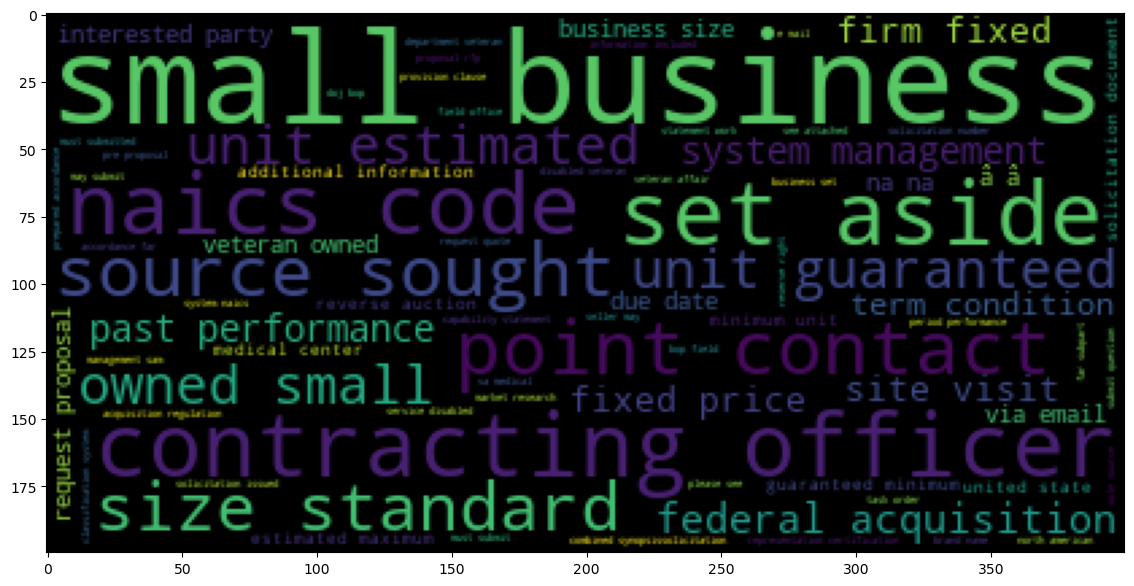

In [8]:
# word cloud showing the frequently appearing words 
# Remove any entries that are 'nan' from the lemmatized descriptions list
desctitle_lemmatized = [item for item in desctitle_lemmatized if item != 'nan']
# Create a WordCloud object with specific configurations: black background, limit to 100 words, and set font size
wc = WordCloud(background_color='black',max_words=1000,random_state=42,max_font_size=100)
# Generate a word cloud using the combined text from the lemmatized descriptions
wc.generate(' '.join(desctitle_lemmatized))
plt.figure(figsize=(50, 7))
plt.imshow(wc)
plt.show()

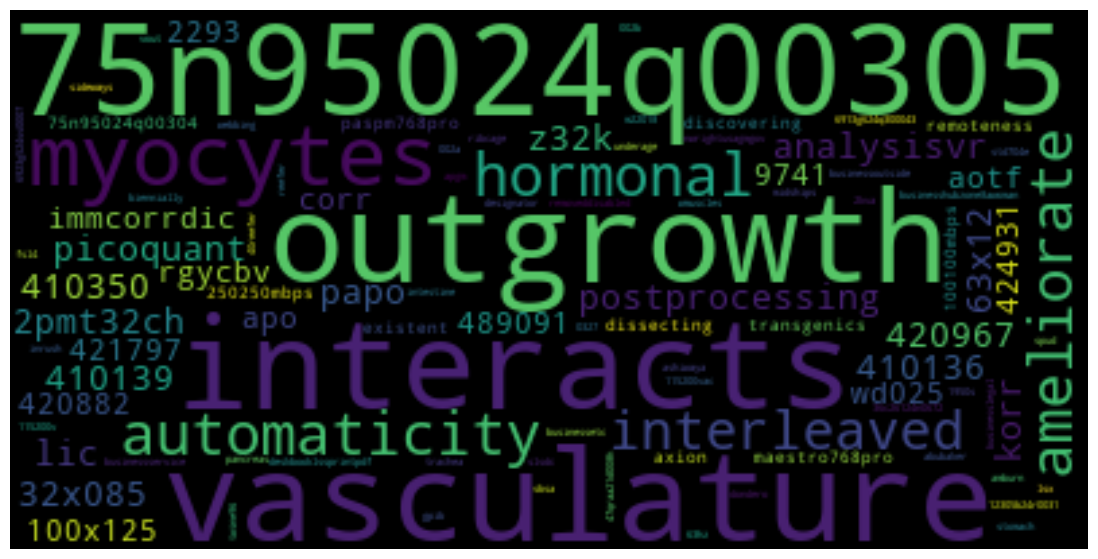

In [9]:
# word cloud showing the words appearing the fewer times
# Join all the texts into a single string
text = ' '.join(desctitle_lemmatized)
# Count word frequencies
word_counts = Counter(text.split())
# Invert frequencies
max_freq = max(word_counts.values())
inverted_freq = {word: max_freq - freq + 1 for word, freq in word_counts.items()}
# Generate the WordCloud using inverted frequencies
wc = WordCloud(background_color='black', max_words=1000, random_state=42, max_font_size=100)
wc.generate_from_frequencies(inverted_freq)
# Plot the WordCloud
plt.figure(figsize=(15, 7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [10]:
# Split the 'Title_Desc' column into lists of words and store them in a new column 'Title_Desc_lst'
samgov_data_5yrs['Title_Desc_lst']=samgov_data_5yrs['Title_Desc'].str.split(' ')
samgov_data_5yrs.head(1)

,Title,Sol#,Department/Ind.Agency,AwardNumber,AwardDate,PostedDate,Award$,Awardee,Link,Description,Title_Desc,Title_Description_c_sw_stm,Title_Description_c_sw_lem,Title_Desc_lst
1,Zeiss LSM980 Microscope Upgrade,75N95024Q00305,"HEALTH AND HUMAN SERVICES, DEPARTMENT OF",<NA>,NaT,2024-05-21,<NA>,<NA>,https://sam.gov/opp/5417ce1082b84ea182c41aa3631aee5b/view,SAM.gov SOURCES SOUGHT NOTICE Solicitation Number: 75N95024Q00305 Title: Zeiss LSM980 Microscope Upgrade Classification Code: 6640 NAICS Code: 334516 Description: Analytical Laboratory Instru...,sam.gov sources sought solicitation number: 75n95024q00305 title: zeiss lsm980 microscope upgrade classification code: 6640 naics code: 334516 description: analytical laboratory instrument ...,samgov sourc sought solicit number 75n95024q00305 titl zeiss lsm980 microscop upgrad classif code 6640 naic code 334516 descript analyt laboratori instrument manufactur sourc sought solicit propos...,samgov source sought solicitation number 75n95024q00305 title zeiss lsm980 microscope upgrade classification code 6640 naics code 334516 description analytical laboratory instrument manufacturing ...,"[sam.gov, sources, sought, , , solicitation, number:, 75n95024q00305, title: , zeiss, lsm980, microscope, upgrade, classification, code: , 6640, naics, code: , 334516, description: , analytical, ..."


In [11]:
# Define the keywords to filter the dataframe
keywords = [" ai ",
            'artificial intelligence',
            ' iot ',
            'machine learning',
            'deep learning',
            'neural network',
            'data science',
            'cloud computing',
            "natural language processing",
            " nlp ",
            "robot",
            "robotics",
            "internet of things"]

In [12]:
# Function to check if text contains any of the keywords
def contains_keywords(text, keywords):
    for keyword in keywords:
        if keyword in text:
            return True
    return False

def keyword(text, keywords):
    for keywd in keywords:
        if keywd in text:
            return keywd
    return False

# Apply the function to the DataFrame
samgov_data_5yrs['Title_Desc_lower']=samgov_data_5yrs['Title_Desc'].str.lower()
samgov_data_5yrs['contains_keywords'] = samgov_data_5yrs['Title_Desc_lower'].apply(lambda x: contains_keywords(x, keywords))
samgov_data_5yrs['keyword'] = samgov_data_5yrs['Title_Desc_lower'].apply(lambda x: keyword(x, keywords))

# Filter rows that contain the keywords
filtered_df = samgov_data_5yrs[samgov_data_5yrs['contains_keywords']]
print('Total number of relevent contracts:',filtered_df.contains_keywords.sum())

Total number of relevent contracts: 156


In [13]:
# displaying the distribtuion of contracts with respect to keyword
filtered_df.groupby('keyword')['Title'].count().reset_index()

,keyword,Title
0,ai,25
1,iot,2
2,artificial intelligence,19
3,cloud computing,10
4,data science,2
5,deep learning,3
6,machine learning,11
7,natural language processing,1
8,robot,83


In [14]:
# displaying the distribtuion of contracts with respect to department
filtered_df.groupby('Department/Ind.Agency')['Title'].count().reset_index()

,Department/Ind.Agency,Title
0,AGENCY FOR INTERNATIONAL DEVELOPMENT,2
1,"AGRICULTURE, DEPARTMENT OF",1
2,"COMMERCE, DEPARTMENT OF",7
3,"EDUCATION, DEPARTMENT OF",1
4,"ENERGY, DEPARTMENT OF",20
5,ENVIRONMENTAL PROTECTION AGENCY,11
6,GENERAL SERVICES ADMINISTRATION,3
7,"HEALTH AND HUMAN SERVICES, DEPARTMENT OF",16
8,"INTERIOR, DEPARTMENT OF THE",5
9,"JUSTICE, DEPARTMENT OF",4


In [15]:
# Display the filtered DataFrame
filtered_df[['Title','Description', 'keyword', 'contains_keywords']]

,Title,Description,keyword,contains_keywords
2,Maestro Pro Assay System Purchase,SAM.gov SOURCES SOUGHT NOTICE Solicitation Number: 75N95024Q00304 Title: Maestro Pro Assay System Purchase Classification Code: 6640 NAICS Code: 334516 Description: Analytical Laboratory Inst...,data science,True
34,99--DOI-BLM Automated Closeout Robotic Process Notice,The Bureau of Land Management intends to utilize robotic process automation (RPA) to closeout contracts in accordance with FAR 4.804. The contracts to be closed all have an expired period of perfo...,robot,True
523,6515--Orthopedic Surgical Robotic Systems (VA-23-00059232),Number: 36C10G24R0012 Notice Type: Combined Synopsis/Solicitation Synopsis: COMBINED SYNOPSIS/SOLICITATION This is a combined synopsis/solicitation for commercial products prepared in accordance w...,robot,True
828,6530--ME-ScriptPro Robot SP 200 CCC 12 SLOT CS: Tracy Heath,Robotic Prescription Dispensing System,robot,True
836,6525-- Xenon UV Robot,Combined Synopsis/Solicitation Notice Combined Synopsis/Solicitation Notice Page 3 of 3 Combined Synopsis/Solicitation Notice *= Required Field Combined Synopsis/Solicitation Notice Page 1 of 3 (i...,robot,True
1022,Robot Stereotaxic,"This is a Small Business Sources Sought notice. This is NOT a solicitation for proposals, proposal abstracts, or quotations. The purpose of this notice is to obtain information regarding: (1) the ...",robot,True
2755,(SYNOPSIS) USPSC Information Integrity and Resilience (IIR) Advisor,"USAID intends to issue a solicitation for a Personal Services Contract (PSC) for the position Information Integrity and Resilience (IIR) Advisor, GS-14 grade equivalent, for USAID’s Bureau for Dem...",artificial intelligence,True
3087,Service/Maintenance agreement for the TOX21 & Kalypys HTS automated cell-based systems services,"INTRODUCTION PURSUANT TO FAR Subpart 5.2—Synopses of Proposed Contract Actions, THIS IS A PRE-SOLICITATION NOTICE OF A PROPOSED CONTRACT TO ACTION. THIS IS A PRE-SOLICITATION NON-COMPETITIVE NO...",robot,True
3722,W065--REQUEST FOR PROPOSAL | MOBILE PET/CT RENTAL/LEASING SERVICES AT BALTIMORE LOCH RAVEN MEDICAL CENTER | ONE BASE PLUS FOUR OPTION YEARS,STATEMENT OF WORK (SOW) PROJECT: MOBILE PET/CT SERVICES AT BALTIMORE LOCH RAVEN MEDICAL CENTER 1. Background: The Baltimore VA Medical Center (hereafter referred to as BT VAMC ) has identified a n...,ai,True
3723,W065--REQUEST FOR PROPOSAL | MOBILE PET/CT RENTAL/LEASING SERVICES AT BALTIMORE LOCH RAVEN MEDICAL CENTER | ONE BASE PLUS FOUR OPTION YEARS,STATEMENT OF WORK (SOW) PROJECT: MOBILE PET/CT SERVICES AT BALTIMORE LOCH RAVEN MEDICAL CENTER 1. Background: The Baltimore VA Medical Center (hereafter referred to as BT VAMC ) has identified a n...,ai,True


In [16]:
# saving the dataframe to csv
filtered_df.to_csv("AI_contracts.csv", index=True)